# MSDS 7331 Data Mining Lab 3
Professor: Dr. Jake Drew  
Team: Steven Hayden, Josephine MacDaniel, Korey MacVittie, Afreen Siddiqui, Eduardo Cantu

For the 2010 Census, an urban area will comprise a densely settled core of census tracts and/or census blocks that meet minimum population density requirements, along with adjacent territory containing non-residential urban land uses as well as territory with low population density included to link outlying densely settled territory with the densely settled core.  To qualify as an urban area, the territory identified according to criteria must encompass at least 2,500 people, at least 1,500 of which reside outside institutional group quarters.  The Census Bureau identifies two types of urban areas:
https://www.census.gov/geo/reference/ua/urban-rural-2010.html

## Business Understanding

Emergency services is a risky business. In the event of an automobile crash, the risk of serious injury or even death is high, and in such circumstances, literally every second counts. However, we are still in an age of limited resources and land-based vehicles: as such, every department whose job is to respond to such accidents needs every drop of data they can muster to ensure that what resources they have available are deployed as sensibly as possible, to maximize their ability to respond to incidents and minimize threat to life.

In this report, we will attempt to cluster fatal accidents across the nation, to see where accidents are such fatal accidents are more likely to happen. While it may seem to be common sense to assume that they are more likely in regions with denser populations, this may not be the case: part of the role of data science is to take those assumptions and approach them with statistical and mathematical rigor, to either confirm them, or to debunk them. It is the latter which is more important, and the possibility of what we feel is "common sense" being wrong is one of the strongest use cases of this sort of analysis. Oftentimes what we feel to be true is not the case in reality, and when lives are on the line, we need to be much more certain of how we approach situations than to just rely on our guts or instincts.

Our primary goal here is to find clusters within the accident data we've been working with. Specifically, we are looking to confirm or deny our sense that higher population densities would have a proportionally higher number of fatal accidents over time; and we are looking for outliers, regions that don't seem to conform to that assumption, which may warrant redistribution of emergency service resources.

In [2]:
#load Libraries
import pandas as pd
import numpy as np
import seaborn as seaborn
import matplotlib.pyplot as plt
import matplotlib as mp1
from sklearn import datasets, linear_model
from sklearn.metrics import mean_squared_error, r2_score
import folium
from sklearn import metrics
from mpl_toolkits.basemap import Basemap
from sklearn import metrics

In [3]:
#Load Data
Accident_df_2016 = pd.read_csv('https://raw.githubusercontent.com/ecantu75/DataMining_Lab1/master/Data/accident_2016.csv',low_memory=False)
Accident_df_2015 = pd.read_csv('https://raw.githubusercontent.com/ecantu75/DataMining_Lab1/master/Data/accident_2015.csv',low_memory=False)
Accident_df = pd.concat([Accident_df_2015,Accident_df_2016])


#Load Damage Data
Distract_df = pd.read_csv('https://raw.githubusercontent.com/ecantu75/DataMining_Lab1/master/Data/distract.csv',low_memory=False)
Damage_df = pd.read_csv('https://raw.githubusercontent.com/ecantu75/DataMining_Lab1/master/Data/damage.csv',low_memory=False)

#Merge the distract data and damage data
Accident_df = Accident_df.merge(Distract_df,left_on = 'consecutive_number', right_on = 'consecutive_number', how= 'left')
Accident_df = Accident_df.merge(Damage_df,left_on = 'consecutive_number', right_on = 'consecutive_number', how= 'left')


## Data Understanding 1

In this section, we will go over the attributes in our data set, and explain each. These descriptions are taken from the kaggle site for this data, found [here](https://www.kaggle.com/usdot/nhtsa-traffic-fatalities).

There are quite a few variables here - however, many of them are redundant with each other. As should not be surprising when governmental bureaucracy is involved, there are a variety of variables here that are "encoded" and redundant with one another. Much of the information relates to the location of the accident: latitude, longitude, type of roadway, nearest mile marker, type of intersection, and so forth.

| Variable Name | Data Type | Description |
| :- | :- | :- |
| state_number | Interval | Identifies the state in which the crash occurred. The codes are from the General Services Administration’s (GSA) publication of worldwide Geographic Location Codes (GLC). For more info on the codes, please look at section in the pdf: https://crashstats.nhtsa.dot.gov/Api/Public/ViewPublication/812315 |
| state_name | Nominal | Identifies the state in which the crash occurred. The codes are from the General Services Administration’s (GSA) publication of worldwide Geographic Location Codes (GLC). |
| consecutive_number | Interval | Unique case number assigned to each crash. It appears on each data file and is used to merge information from the data files together. xxxxxx Two Characters for State Code followed by Four Characters for Case Number. |
| number_of_vehicle_forms_submitted_all | Interval | Count of the total number of vehicles involved. |
| number_of_motor_vehicles_in_transport_mvit | Interval | Count of the number of vehicles in-transport involved in the crash. Legally parked vehicles are not included. |
| number_of_parked_working_vehicles | Interval | Count of the number of parked and working vehicles involved in the crash. |
| number_of_forms_submitted_for_persons_not_in_motor_vehicles | Interval | Number of Person Forms (Not a Motor Vehicle Occupant) that are applicable to this case (i.e., non-occupants). |
| number_of_persons_not_in_motor_vehicles_in_transport_mvit | Interval | Count of the number of non-motorists in the crash. A non-motorist is defined as a pedestrian, a cyclist, an occupant of a motor vehicle not intransport, a person riding a horse, an occupant of an animal drawn conveyance, person associated with non-motorist conveyance (e.g., baby carriage, skate board, wheelchair), or an other non-motorist (e.g., person outside a trafficway, person in a house). |
| number_of_persons_in_motor_vehicles_in_transport_mvit | Interval | Count of the number of motorists in the crash. A motorist is a driver, passenger or unknown occupant type of a motor vehicle in-transport. |
| number_of_forms_submitted_for_persons_in_motor_vehicles | Interval | Count of the number of Person Level (Motor Vehicle Occupant) Forms that are applicable to this case (i.e., occupants). |
| county | Nominal | Records the location of the unstabilized event with regard to the County. The codes are from the General Services Administration’s (GSA) publication of worldwide Geographic Location Codes (GLC). |
| city | Nominal | Records the location of the unstabilized event with regard to the City. The codes are from the General Services Administration’s (GSA) publication of worldwide Geographic Location Codes (GLC). |
| day_of_crash | Ordinal | Records the day of the month on which the crash occurred. |
| month_of_crash | Ordinal | Records the month in which the crash occurred. For more info on the codes, please look at section in the pdf: https://crashstats.nhtsa.dot.gov/Api/Public/ViewPublication/812315 |
| year_of_crash | Ordinal | Records the year in which the crash occurred. |
| day_of_week | Ordinal | Records the day of the week on which the crash occurred. Sunday is Day 1. |
| hour_of_crash | Ordinal | Records the hour at which the crash occurred. Listed in 24-hour format. |
| minute_of_crash | Ordinal | Records the minutes after the hour at which the crash occurred. |
| national_highway_system | Nominal | Identifies whether this crash occurred on a trafficway that is part of the National Highway System. |
| land_use | Nominal | 1 (Rural), 2 (Urban), 6 (Trafficway Not in State Inventory), 8 (Not Reported) and 9 (Unknown). |
| land_use_name | Nominal | 1 (Rural), 2 (Urban), 6 (Trafficway Not in State Inventory), 8 (Not Reported) and 9 (Unknown). |
| functional_system | Nominal | 01 (Interstate), 02 (Principal Arterial – Other Freeways and Expressways), 03 (Principal Arterial – Other), 04 (Minor Arterial), 05 (Major Collector), 06 (Minor Collector), 07 (Local), 96 (Trafficway Not in State Inventory), 98 (Not Reported), and 99 (Unknown). |
| functional_system_name | Nominal | 01 (Interstate), 02 (Principal Arterial – Other Freeways and Expressways), 03 (Principal Arterial – Other), 04 (Minor Arterial), 05 (Major Collector), 06 (Minor Collector), 07 (Local), 96 (Trafficway Not in State Inventory), 98 (Not Reported), and 99 (Unknown). |
| ownership | Nominal | For more info on the codes, please look at section in the pdf: https://crashstats.nhtsa.dot.gov/Api/Public/ViewPublication/812315 |
| ownership_name | Nominal | For more info on the codes, please look at section in the pdf: https://crashstats.nhtsa.dot.gov/Api/Public/ViewPublication/812315 |
| route_signing | Nominal | Identifies the route signing of the trafficway on which the crash occurred, using a coding system. |
| route_signing_name | Nominal | Identifies the route signing of the trafficway on which the crash occurred. |
| trafficway_identifier | Nominal | Records the trafficway on which the crash occurred. |
| trafficway_identifier_2 | Nominal | Records the trafficway on which the crash occurred. |
| milepoint | Interval | Records the milepoint nearest to the location where the crash occurred, if applicable.
| latitude | Interval | Identifies the location of the crash using Global Position coordinates. This is the position of latitude. |
| longitude | Interval | Identifies the location of the crash using Global Position coordinates. |
| special_jurisdiction | Nominal | Identifies if the location on the trafficway where the crash occurred qualifies as a Special Jurisdiction even though it may be patrolled by state, county or local police (e.g., all State highways running through Indian reservations are under the jurisdiction of the Indian reservation). |
| special_jurisdiction_name | Nominal | Identifies if the location on the trafficway where the crash occurred qualifies as a Special Jurisdiction even though it may be patrolled by state, county or local police (e.g., all State highways running through Indian reservations are under the jurisdiction of the Indian reservation). |
| first_harmful_event | Nominal | Describes the first injury or damage producing event of the crash. For more info on the codes, please look at section in the pdf: https://crashstats.nhtsa.dot.gov/Api/Public/ViewPublication/812315 |
| first_harmful_event_name | Nominal | Describes the first injury or damage producing event of the crash. |
| manner_of_collision | Nominal | Describes the orientation of two motor vehicles in-transport when they are involved in the “First Harmful Event” of a collision crash. If the “First Harmful Event” is not a collision between two motor vehicles in-transport it is classified as such. For more info on the codes, please look at section in the pdf: https://crashstats.nhtsa.dot.gov/Api/Public/ViewPublication/812315 |
| manner_of_collision_name | Nominal | Describes the orientation of two motor vehicles in-transport when they are involved in the “First Harmful Event” of a collision crash. If the “First Harmful Event” is not a collision between two motor vehicles in-transport it is classified as such. |
| relation_to_junction_within_interchange_area | Nominal | Identifies the crash's location with respect to presence in an interchange area. The coding of this data element is done in two sub-fields (see also C20B) and is based on the location of the “First Harmful Event” of the crash. (0) No (1) Yes (8) Not Reported (9) Unknown |
| relation_to_junction_specific_location | Nominal | Identifies the crash's location with respect to presence in or proximity to components typically in junction or interchange areas. The coding of this data element is done in two sub-fields (see also C20A) and is based on the location of the “First Harmful Event” of the crash. For more info on the codes, please look at section in the pdf: https://crashstats.nhtsa.dot.gov/Api/Public/ViewPublication/812315 |
| relation_to_junction_specific_location_name | Nominal | Identifies the crash's location with respect to presence in or proximity to components typically in junction or interchange areas. The coding of this data element is done in two sub-fields (see also C20A) and is based on the location of the “First Harmful Event” of the crash. |
| type_of_intersection | Nominal | Identifies and allows separation of various intersection types. (1) Not an Intersection (2) Four-Way Intersection (3) T-Intersection (4) Y-Intersection (5) Traffic Circle (6) Roundabout (7) Five-Point, or More (10) L-Intersection (98) Not Reported (99) Unknown |
| work_zone | Nominal | Identifies a motor vehicle traffic crash in which the first harmful event occurs within the boundaries of a work zone or on an approach to or exit from a work zone, resulting from an activity, behavior, or control related to the movement of the traffic units through the work zone. (0) None (1) Construction (2) Maintenance -- Construction or Maintenance (3) Utility (4) Work Zone, Type Unknown (--) Not Reported |
| relation_to_trafficway | Nominal | Identifies the location of the crash as it relates to its position within or outside the trafficway based on the “First Harmful Event.” For more info on the codes, please look at section in the pdf: https://crashstats.nhtsa.dot.gov/Api/Public/ViewPublication/812315 |
| relation_to_trafficway_name | Nominal | Identifies the location of the crash as it relates to its position within or outside the trafficway based on the “First Harmful Event.” |
| light_condition | Nominal | Records the type/level of light that existed at the time of the crash as indicated in the case material. For more info on the codes, please look at section in the pdf: https://crashstats.nhtsa.dot.gov/Api/Public/ViewPublication/812315 |
| light_condition_name | Nominal | Records the type/level of light that existed at the time of the crash as indicated in the case material. |
| atmospheric_conditions_1 | Nominal | Records the prevailing atmospheric conditions that existed at the time of the crash as indicated in the case material. For more info on the codes, please look at section in the pdf: https://crashstats.nhtsa.dot.gov/Api/Public/ViewPublication/812315 |
| atmospheric_conditions_1_name | Nominal | Records the prevailing atmospheric conditions that existed at the time of the crash as indicated in the case material. |
| atmospheric_conditions_2 | Nominal | Records the prevailing atmospheric conditions that existed at the time of the crash as indicated in the case material. For more info on the codes, please look at section in the pdf: https://crashstats.nhtsa.dot.gov/Api/Public/ViewPublication/812315 |
| atmospheric_conditions_2_name | Nominal | Records the prevailing atmospheric conditions that existed at the time of the crash as indicated in the case material. |
| atmospheric_conditions | Nominal | Records the prevailing atmospheric conditions that existed at the time of the crash as indicated in the case material. For more info on the codes, please look at section in the pdf: https://crashstats.nhtsa.dot.gov/Api/Public/ViewPublication/812315 |
| atmospheric_conditions_name | Nominal | Records the prevailing atmospheric conditions that existed at the time of the crash as indicated in the case material. |
| school_bus_related | Nominal | Identifies if a school bus, or motor vehicle functioning as a school bus, is related to the crash. (0) No (1) Yes (--) Not Reported |
| rail_grade_crossing_identifier | Nominal | Identifies if the crash occurred in or near a rail grade crossing. |
| hour_of_notification | Interval | Records the hour that emergency medical service was notified, in 24-hour format. |
| minute_of_notification | Interval | Records the minutes after the hour that emergency medical service was notified. |
| hour_of_arrival_at_scene | Interval | Records the hour that emergency medical service arrived on the crash scene, in 24-hour format. |
| minute_of_arrival_at_scene | Interval | Records the minutes after the hour that emergency medical service arrived on the crash scene. |
| hour_of_ems_arrival_at_hospital | Interval | Records the hour that emergency medical service arrived at the treatment facility to which it was transporting victims of the crash, in 24-hour format. |
| minute_of_ems_arrival_at_hospital | Interval | Records the minutes after the hour that emergency medical service arrived at the treatment facility to which it was transporting victims of the crash. |
| related_factors_crash_level_1 | Nominal | Records factors related to the crash expressed by the investigating officer. For more info on the codes, please look at section in the pdf: https://crashstats.nhtsa.dot.gov/Api/Public/ViewPublication/812315 |
| related_factors_crash_level_1_name | Nominal | Records factors related to the crash expressed by the investigating officer. |
| related_factors_crash_level_2 | Nominal | Records factors related to the crash expressed by the investigating officer. For more info on the codes, please look at section in the pdf: https://crashstats.nhtsa.dot.gov/Api/Public/ViewPublication/812315 |
| related_factors_crash_level_2_name | Nominal | Records factors related to the crash expressed by the investigating officer. |
| related_factors_crash_level_3 | Nominal | Records factors related to the crash expressed by the investigating officer. For more info on the codes, please look at section in the pdf: https://crashstats.nhtsa.dot.gov/Api/Public/ViewPublication/812315 |
| related_factors_crash_level_3_name | Nominal | Records factors related to the crash expressed by the investigating officer. |
| number_of_fatalities | Interval | Records the number of fatally injured persons in the crash. |
| number_of_drunk_drivers | Interval | Records the number of drunk drivers involved in the crash. |
| timestamp_of_crash | Nominal | This data element records the date and time on which the crash occurred. |
| Clock points | Nominal | Records the count of damage points on the side of the vehicles. |
| No Damage | Nominal | Records the count of vehicles with no damage. |
| Top | Nominal | Records the count of vehicles with damage on the roof. |
| Undercarriage | Nominal | Records the count of vehicles with damage on the undercarriage. |
| Unknown | Nominal | Records the count of vehicles with unknow damage on. |
| By a Moving Object in Vehicle | Nominal | Count of drivers that were distracted by a moving object in the vehicle. |
| By Other Occupant(s) | Nominal | Count of drivers that were distracted by other occupant(s). |
| Careless/Inattentive | Nominal | Count of drivers that were careless or inattentive. |
| Distracted by Outside Person, Object or Event | Nominal | Count of drivers that were distracted by outside Person, Object or Event |
| Distraction (Distracted), Details Unknown | Nominal | Count of drivers that were distracted by a unknown reason. |
| Distraction/Inattention | Nominal | Count of drivers that were inattentive. |
| Eating or Drinking | Nominal | Count of drivers that were eating or drinking. |
| Inattention (Inattentive), Details Unknown | Nominal | count of drivers that were inattentive with unkown details. |
| Looked But Did Not See | Nominal | Count of drivers that looked but did not see. |
| Lost In Thought/Day Dreaming | Nominal | Count of drivers that lost in thought/day dreaming. |
| No Driver Present/Unknown if Driver Present | Nominal | Count of vehicles unknows if driver was present. |
| Not Distracted | Nominal | Count of drivers that were not distracted. |
| Not Reported | Nominal | Count of vehicles that did not have a distraction reported. |
| Other Cellular Phone Related | Nominal | Count of drivers that were distracted related to a cell phone. |
| Other Distraction | Nominal | Count of drivers that were distracted due to other circumstances. |
| Smoking Related | Nominal | Count of drivers that were distracted due to smoking. |
| Unknown if Distracted | Nominal | Count of drivers that were unknow if they were distracted. |
| While Adjusting Audio or Climate Controls | Nominal | Count of drivers that were distracted adjusting audio or climate controls. |
| While Manipulating Cellular Phone | Nominal | Count of drivers that were distracted manipulating a cell phone. |
| While Talking or Listening to Cellular Phone | Nominal | Count of drivers that were distracted due Talking/Listening to a cell phone. |
| While Using or Reaching For Device/Object Brought Into Vehicle | Nominal | Count of drivers that were distracted due to using or reaching for device/object. |
| While Using Other Component/Controls Integral to Vehicle | Nominal | Count of drivers that were distracted due to using other component/controls integral to vehicle. |

In [4]:
# Displays the record count of non-null Values per attribute and their data type. 
Accident_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 66978 entries, 0 to 66977
Data columns (total 99 columns):
Unnamed: 0                                                        66978 non-null int64
state_number                                                      66978 non-null int64
state_name                                                        66978 non-null object
consecutive_number                                                66978 non-null int64
number_of_vehicle_forms_submitted_all                             66978 non-null int64
number_of_motor_vehicles_in_transport_mvit                        66978 non-null int64
number_of_parked_working_vehicles                                 66978 non-null int64
number_of_forms_submitted_for_persons_not_in_motor_vehicles       66978 non-null int64
number_of_persons_not_in_motor_vehicles_in_transport_mvit         66978 non-null int64
number_of_persons_in_motor_vehicles_in_transport_mvit             66978 non-null int64
number_of_forms_subm

**Duplicate Removal**

In [5]:
#Print shape before duplicate removal
print("Data Shape before duplicate Removal:", Accident_df.shape)

Data Shape before duplicate Removal: (66978, 99)


In [6]:
#check for duplicate records. It displays the maximum count of a duplicated record. 
#Any value greater than 1 would mean that the data has duplicates
Accident_df['consecutive_number'].value_counts().max()

2

In [7]:
#Drop duplicate records and keeps the most recent record. We assume the most resent is the most accurate 
Accident_df = Accident_df.drop_duplicates(['consecutive_number'],keep = 'last')

#check for duplicate records. It displays the maximum count of a duplicated record . 
#Any value greater than 1 would mean that the data has duplicates
Accident_df['consecutive_number'].value_counts().max()

1

In [8]:
#Print shape After duplicate removal
print("Data Shape After duplicate Removal:", Accident_df.shape)

Data Shape After duplicate Removal: (35379, 99)


In [9]:
#Displays all the available attributes on the dataset
Accident_df=Accident_df.reset_index()
Accident_df.count()

index                                                             35379
Unnamed: 0                                                        35379
state_number                                                      35379
state_name                                                        35379
consecutive_number                                                35379
number_of_vehicle_forms_submitted_all                             35379
number_of_motor_vehicles_in_transport_mvit                        35379
number_of_parked_working_vehicles                                 35379
number_of_forms_submitted_for_persons_not_in_motor_vehicles       35379
number_of_persons_not_in_motor_vehicles_in_transport_mvit         35379
number_of_persons_in_motor_vehicles_in_transport_mvit             35379
number_of_forms_submitted_for_persons_in_motor_vehicles           35379
county                                                            35379
city                                                            

#### Data Type Colunm Count
This will look into the number of attributes per variable type

In [10]:
# Take a look a at the data type on the Merged Data
dtype_df=Accident_df.dtypes.reset_index()
dtype_df.columns=["Count","ColumnType"]
dtype_df.groupby("ColumnType").aggregate('count').reset_index()

,ColumnType,Count
0,int64,45
1,float64,30
2,object,25


#### Description of the Categorical Variables   (DO WE NEED THIS)

In [11]:
# Describe the Categorical Objects
list_include = ['object']
Accident_df.describe(include=list_include).T

,count,unique,top,freq
state_name,35379,51,Texas,3495
land_use_name,35379,5,Rural,17181
functional_system_name,35379,10,Principal Arterial – Other,10396
ownership_name,35379,25,State Highway Agency,18486
route_signing_name,35379,9,State Highway,10498
trafficway_identifier,35379,16928,I-10,312
trafficway_identifier_2,9432,8138,MAIN ST,26
special_jurisdiction_name,35379,7,No Special Jurisdiction (Includes National For...,34974
first_harmful_event_name,35379,51,Motor Vehicle in Transport,13432
manner_of_collision_name,35379,11,Not Collision with Motor Vehicle in Transport ...,21900


#### (DO WE NEED THIS)

In [ ]:
####Do not Run- Long run time




#Frequency Histograms for the unbalanced attributes
#for col in ['school_bus_related','special_jurisdiction_name','special_jurisdiction_name','relation_to_junction_within_interchange_area',
#           'work_zone','atmospheric_conditions_2_name','rail_grade_crossing_identifier','related_factors_crash_level_1_name','related_factors_crash_level_2_name',
#           'related_factors_crash_level_3_name']:

from matplotlib.ticker import NullFormatter  # useful for `logit` scale
list_include = ['object']
i=1
for col in Accident_df.select_dtypes(include=list_include).columns:
    if col not in ['trafficway_identifier','trafficway_identifier_2','timestamp_of_crash']:
        if i<=3:
            #plt.figure(figsize=(10,4))
            plt.subplot(1,3,i)
            plt.hist(Accident_df[col], bins=len(Accident_df[col].unique()))
            plt.title(col,size=7.8)
            plt.xlabel('Class', size=5)
            plt.ylabel('Class frequency', size=7)
            plt.xticks(rotation='vertical', size=4)
            plt.yticks(size=7)
            i=i+1
        else:
            plt.subplots_adjust(top=.7, bottom=0.4, left=0.01, right=1.1, hspace=0.25, wspace=2)
            plt.show()
            i = 1

plt.subplots_adjust(top=.7, bottom=0.4, left=0.01, right=1.1, hspace=0.25, wspace=2)
plt.show()



There are attritbutes that show extreme imbalance in the dataset. These attributes do not add value to the prediction since most the values are the same. Also, when doing cross validation there is a high probaility that the test set only chooses the highest class.

**Imbalance Attributes:**  
* school_bus_related  
* special_jurisdiction_name
* relation_to_junction_within_interchange_area
* work_zone
* atmospheric_conditions_1_name
* atmospheric_conditions_2_name
* rail_grade_crossing_identifier
* related_factors_crash_level_1_name
* related_factors_crash_level_2_name
* related_factors_crash_level_3_name
* trafficway_identifier
* trafficway_identifier_2

#### Description of the Float Variables

In [12]:
# Describe the Float Objects
list_include = ['float64']
Accident_df.describe(include=list_include).T

,count,mean,std,min,25%,50%,75%,max
latitude,35379.0,36.925757,7.203311,19.101319,32.994856,36.287044,40.610408,99.9999
longitude,35379.0,-85.298045,87.623932,-174.204181,-97.902897,-87.767303,-81.459606,999.9999
By a Moving Object in Vehicle,35364.0,0.000339,0.018418,0.000000,0.000000,0.000000,0.000000,1.0000
By Other Occupant(s),35364.0,0.005033,0.071167,0.000000,0.000000,0.000000,0.000000,2.0000
Careless/Inattentive,35364.0,0.001414,0.037575,0.000000,0.000000,0.000000,0.000000,1.0000
"Distracted by Outside Person, Object or Event",35364.0,0.006080,0.084699,0.000000,0.000000,0.000000,0.000000,6.0000
"Distraction (Distracted), Details Unknown",35364.0,0.007748,0.089280,0.000000,0.000000,0.000000,0.000000,2.0000
Distraction/Careless,35364.0,0.000198,0.014068,0.000000,0.000000,0.000000,0.000000,1.0000
Distraction/Inattention,35364.0,0.012470,0.111988,0.000000,0.000000,0.000000,0.000000,2.0000
Eating or Drinking,35364.0,0.001414,0.037575,0.000000,0.000000,0.000000,0.000000,1.0000


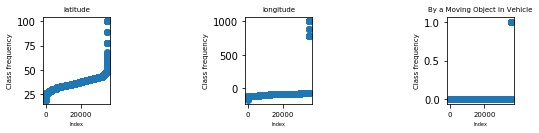

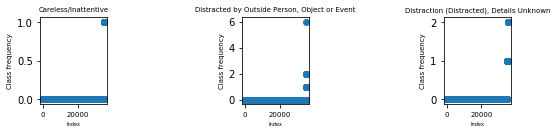

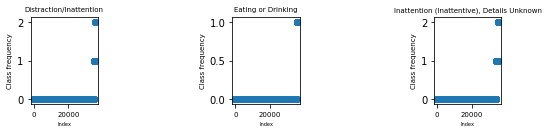

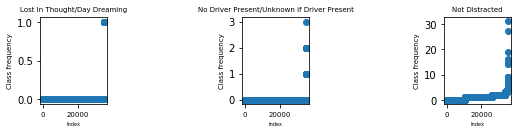

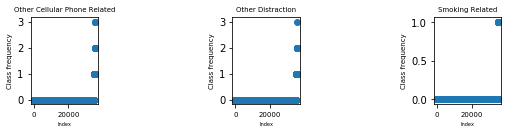

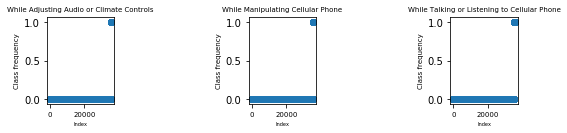

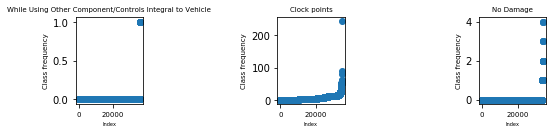

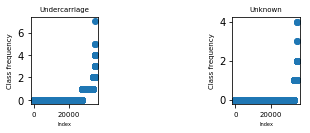

In [13]:
# Verify all float values
list_include = ['float64']
i=1
for col in Accident_df.select_dtypes(include=list_include).columns:
    if i<=3:
        #plt.figure(figsize=(10,4))
        plt.subplot(1,3,i)
        plt.scatter(range(Accident_df.shape[0]),np.sort(Accident_df[col].values))
        plt.xlabel('Index', size=5)
        plt.title(col, size=7)
        plt.ylabel('Class frequency', size=7)
        plt.xticks(size=7)
        i = i + 1
    else:
        plt.subplots_adjust(top=.7, bottom=0.4, left=0.01, right=1.1, hspace=0.25, wspace=2)
        plt.show()
        i = 1
plt.subplots_adjust(top=.7, bottom=0.4, left=0.01, right=1.1, hspace=0.25, wspace=2)
plt.show()   

**Binary classes in Float:**
* By a Moving Object in Vehicle
* By Other Occupant(s)	
* Careless/Inattentive
* Distraction/Careless
* Eating or Drinking
* Lost In Thought/Day Dreaming
* Smoking Related
* While Adjusting Audio or Climate Controls
* While Manipulating Cellular Phone
* While Talking or Listening to Cellular Phone
* While Using or Reaching For Device/Object Brought Into Vehicle
* While Using Other Component/Controls Integral to Vehicle

**Float Classes that can be integers**
* Distracted by Outside Person, Object or Event
* Distraction (Distracted), Details Unknown
* Distraction/Inattention
* Inattention (Inattentive), Details Unknown
* Looked But Did Not See 
* No Driver Present/Unknown if Driver Present
* Not Distracted
* Not Reported
* Other Cellular Phone Related
* Other Distraction
* Unknown if Distracted	
* Clock points
* No Damage
* Top
* Undercarriage
* Unknown

The only true float class is the **Fatalities_ratio, latitude, and longitude**, all other classes can be converted to integer.

#### Missing Values Per Column

In [14]:
# Missing Values
missing_df=Accident_df.isnull().sum(axis=0).reset_index()
missing_df.columns=['ColumnName','MissingCount']
missing_df=missing_df.ix[missing_df['MissingCount']>0]
missing_df=missing_df.sort_values(by='MissingCount')

missing_df = missing_df.merge(dtype_df,left_on = 'ColumnName', right_on = 'Count', how= 'left')
missing_df

C:\Users\shayden\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:4: DeprecationWarning: 
.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexing.html#ix-indexer-is-deprecated
  after removing the cwd from sys.path.


,ColumnName,MissingCount,Count,ColumnType
0,Not Reported,15,Not Reported,float64
1,While Using or Reaching For Device/Object Brou...,15,While Using or Reaching For Device/Object Brou...,float64
2,While Talking or Listening to Cellular Phone,15,While Talking or Listening to Cellular Phone,float64
3,While Manipulating Cellular Phone,15,While Manipulating Cellular Phone,float64
4,While Adjusting Audio or Climate Controls,15,While Adjusting Audio or Climate Controls,float64
5,Unknown if Distracted,15,Unknown if Distracted,float64
6,Smoking Related,15,Smoking Related,float64
7,Other Distraction,15,Other Distraction,float64
8,Other Cellular Phone Related,15,Other Cellular Phone Related,float64
9,Not Distracted,15,Not Distracted,float64


In [15]:
list_include = ['float64']
# Add a 99 to all float missing values. 99 would mean that it was NA before. This has to be done in order to change the data type to integer.
# There is still a need to know what to do with these observations.
for col in Accident_df.select_dtypes(include=list_include).columns:
    if col not in ['Fatalities_ratio']:
        Accident_df[col].fillna(value=99, inplace=True)

Review Missing Values after adding value '99' to all the missing values in the above attributes. As expected only the Traffic_indentifier_2 still show 12,111 null values. Therefore, this attribute would be removed.

In [16]:
# Review missing Values Again.
# Missing Values
missing_df=Accident_df.isnull().sum(axis=0).reset_index()
missing_df.columns=['ColumnName','MissingCount']
missing_df=missing_df.ix[missing_df['MissingCount']>0]
missing_df=missing_df.sort_values(by='MissingCount')

missing_df = missing_df.merge(dtype_df,left_on = 'ColumnName', right_on = 'Count', how= 'left')
missing_df

C:\Users\shayden\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:5: DeprecationWarning: 
.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexing.html#ix-indexer-is-deprecated
  """


,ColumnName,MissingCount,Count,ColumnType
0,trafficway_identifier_2,25947,trafficway_identifier_2,object


In [17]:
list_include = ['float64']
# Convert all floats into integers except for 'Fatalities_ratio'
for col in Accident_df.select_dtypes(include=list_include).columns:
    if col not in ['Fatalities_ratio','latitude','longitude']:
        Accident_df[col] = Accident_df[col].astype(int)


Check for the datatype again.

In [18]:
# Take a look a at the data type on the Merged Data
dtype_df=Accident_df.dtypes.reset_index()
dtype_df.columns=["Count","ColumnType"]
dtype_df.groupby("ColumnType").aggregate('count').reset_index()

,ColumnType,Count
0,int32,28
1,int64,45
2,float64,2
3,object,25


We need to make a subset of data once with the varibles we are going to use for clustering. We will use Longitued and Latitude for the location of the accident, but we will also cluster on functional_system to identify the type of road the accident was on. 

Remove observations that were recoreded as missing in the longitude and latitude.
https://www.kaggle.com/usdot/nhtsa-traffic-fatalities

"This is the position of longitude. DDDDDDD (DDD.DDDD – Decimal Degrees) DDD.DDDD Actual Degrees 777.7777 Not Reported 888.8888 Not Available (If State Exempt) 999.9999 Unknown"

We will also remove observation from the third variable. The functional system is the type of the road the accident happened on. Functional systems labeled as 98 and 99 are either unreported or unknow, so we want to remove these.

In [19]:
#Create a list to remove desired observations 
Obs_to_remove_Long_Lad=[777.7777,888.8888,999.9999]
Obs_to_remove_functional_system= [98,99]
Obs_to_remove_Land_use=[8,9,]

#Counts how many obs will be removed
Count_of_Obs_Removed =Accident_df[(Accident_df['functional_system'].isin(Obs_to_remove_functional_system) | Accident_df['longitude'].isin(Obs_to_remove_Long_Lad)| Accident_df['land_use'].isin(Obs_to_remove_Land_use))].count()
print(Count_of_Obs_Removed['consecutive_number'],'observations have missing values')





1343 observations have missing values


In [20]:
#remove observations

Accident_df1= Accident_df[~(Accident_df['functional_system'].isin(Obs_to_remove_functional_system)) & ~(Accident_df['longitude'].isin(Obs_to_remove_Long_Lad)) & ~(Accident_df['land_use'].isin(Obs_to_remove_Land_use))]
print(Accident_df1['consecutive_number'].count(),'observations remaining')



34036 observations remaining


### Data Understanding 2

#### Description of the Integer Values

In [21]:
# Describe the Integer Objects
list_include = ['int64','int32']
Accident_df1.describe(include=list_include).T

,count,mean,std,min,25%,50%,75%,max
index,34036.0,48747.774415,11245.239136,172.0,40468.75,49068.5,57660.25,66977.0
Unnamed: 0,34036.0,17075.881978,9886.593122,0.0,8660.75,16908.5,25343.25,34438.0
state_number,34036.0,26.744829,16.088227,1.0,12.00,26.0,41.00,56.0
consecutive_number,34036.0,268176.874251,160762.253242,10001.0,121986.75,260554.5,410184.25,560130.0
number_of_vehicle_forms_submitted_all,34036.0,1.560994,0.856064,1.0,1.00,1.0,2.00,64.0
number_of_motor_vehicles_in_transport_mvit,34036.0,1.522006,0.813478,1.0,1.00,1.0,2.00,64.0
number_of_parked_working_vehicles,34036.0,0.038988,0.296261,0.0,0.00,0.0,0.00,11.0
number_of_forms_submitted_for_persons_not_in_motor_vehicles,34036.0,0.215360,0.468970,0.0,0.00,0.0,0.00,11.0
number_of_persons_not_in_motor_vehicles_in_transport_mvit,34036.0,0.225291,0.495565,0.0,0.00,0.0,0.00,11.0
number_of_persons_in_motor_vehicles_in_transport_mvit,34036.0,2.261811,1.892715,0.0,1.00,2.0,3.00,120.0


In [22]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.basemap import Basemap


In [23]:
#Convert longitude and latitude columns into list to remove missing index values
data=pd.DataFrame(data=Accident_df1['latitude'].tolist())
data_3D=pd.DataFrame(data=Accident_df1['functional_system'].tolist())
#Combine the two columns back together into dataframe without missing index values
#data['land_use']=Accident_df1['land_use'].tolist()
data['longitude']=Accident_df1['longitude'].tolist()
data_3D['land_use']=Accident_df1['land_use'].tolist()
data_3D['latitude'] = Accident_df1['latitude'].tolist()
data_3D['longitude'] = Accident_df1['longitude'].tolist()
data.columns=['latitude','longitude']
data_3D.columns=['functional_system','land_use','latitude','longitude']






In [24]:
data_3D.describe()


,functional_system,land_use,latitude,longitude
count,34036.000000,34036.000000,34036.000000,34036.000000
mean,4.071513,1.510636,36.678736,-92.144393
std,5.337109,0.556626,5.237632,15.063619
min,1.000000,1.000000,19.101319,-174.204181
25%,3.000000,1.000000,33.303747,-97.885513
50%,4.000000,1.000000,36.486151,-87.529654
75%,5.000000,2.000000,40.645637,-81.437962
max,96.000000,6.000000,68.344956,-67.110531


{'whiskers': [<matplotlib.lines.Line2D at 0x18ec1e534a8>,
 'caps': [<matplotlib.lines.Line2D at 0x18ec1e53cf8>,
 'boxes': [<matplotlib.lines.Line2D at 0x18ec1e46f98>],
 'medians': [<matplotlib.lines.Line2D at 0x18ec1e5c588>],
 'fliers': [<matplotlib.lines.Line2D at 0x18ec1e5c9b0>],
 'means': []}

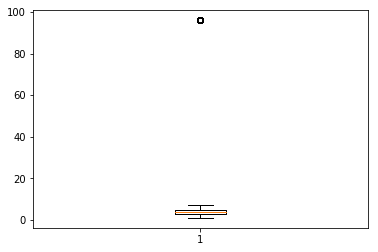

In [25]:
plt.boxplot(data_3D['functional_system'])

| Variable Name | Description |
| :- | :- 
| state_number | Interval  |


In [37]:
#break down of counts by functional system 
(data_3D.groupby('functional_system').count()/len(data_3D))*100

,land_use,latitude,longitude
functional_system,,,
1,13.230109,13.230109,13.230109
2,5.191562,5.191562,5.191562
3,30.353155,30.353155,30.353155
4,19.685039,19.685039,19.685039
5,14.801974,14.801974,14.801974
6,4.110354,4.110354,4.110354
7,12.328123,12.328123,12.328123
96,0.299683,0.299683,0.299683


We have 34 thousand records after cleaning the data set. The table below break down the accidents by 'functional_system'. This is the road type that the accident happened on. We can see that most accidents happened on Principal Arterial – Other.

| functional_system | Description |
| :- | :- |
| state_number | Interval | |


In [ ]:
#This cellblock generates the colors used for the clusters in the map
#gets Land use into df for unique values


df = pd.DataFrame(data=data_3D)
Y_Unique = df['land_use'].unique()


#list of colors to be used for clusters
Y_Color = np.zeros((0, 0))
colors_list = [
    'red',
    'blue',
    'gray',
    'darkred',
    'lightred',
    'orange',
    'beige',
    'green',
    'darkgreen',
    'lightgreen',
    'darkblue',
    'lightblue',
    'purple',
    'darkpurple',
    'pink',
    'cadetblue',
    'lightgray',
    'black'
]

#loops through cluster numbers and gives them a color 
g = itertools.cycle(colors_list)
for n in range(0,len(Y_Unique)):
    Y_Color = np.append(Y_Color,next(g))
    

Cluster_and_color= [Y_Unique.astype(int),Y_Color]
Cluster_and_color= pd.DataFrame(data=Cluster_and_color)
Cluster_and_color = np.transpose(Cluster_and_color)
Cluster_and_color.columns=['Cluster','color']


In [ ]:

#Put land use into df and change data type
Y_ = pd.DataFrame(data=data_3D['land_use'])
Y_.columns=['Cluster']
Cluster_and_color['Cluster'] = Cluster_and_color.Cluster.astype(int)
Cluster_and_color = Cluster_and_color.merge(data_3D, left_on='Cluster',right_on='land_use',how='right')


Initial look at the accidents on a map to see if there are any clusters we can see with the eye. We can see clusters around cities, and we would expect the model to group these data points together.

In [ ]:
# Make an empty map
m = folium.Map(location=[55.007351, -99.357758], tiles="Mapbox Bright", zoom_start=3)


# add marker one by one on the map
for i in range(0,len(Cluster_and_color)):
    folium.Circle([Cluster_and_color.latitude[i], Cluster_and_color.longitude[i]],
                radius = 100,
                color=Cluster_and_color.color[i]).add_to(m)





# This function by ocefpaf as a work around for the map not rendering with large datasets. https://github.com/python-visualization/folium/issues/812
def embed_map(m):
    from IPython.display import IFrame

    m.save('index.html')
    return IFrame('index.html', width='100%', height='750px')
embed_map(m)


### Kmeans Model

In [ ]:
data.head()
data.shape

In [ ]:
#Source: https://www.datasciencecentral.com/profiles/blogs/python-implementing-a-k-means-algorithm-with-sklearn
# The code below is to Devise an elbow curve to select the optimal number of clusters (k) for K-means clustering.
import pandas

import pylab as pl

from sklearn.cluster import KMeans

from sklearn.decomposition import PCA

Y = data[['latitude']]

X = data[['longitude']]

Nc = range(1, 20)

kmeans = [KMeans(n_clusters=i) for i in Nc]

kmeans

score = [kmeans[i].fit(Y).score(Y) for i in range(len(kmeans))]

score

pl.plot(Nc,score)

pl.xlabel('Number of Clusters')

pl.ylabel('Score')

pl.title('Elbow Curve')

pl.show()

From the above elbow graphs the number of suggested clusters with this data is 2.

In [ ]:
#K-Means Algorithm with cluster size =5
#source : https://jakevdp.github.io/PythonDataScienceHandbook/05.11-k-means.html

%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns; sns.set()  # for plot styling
import numpy as np

from sklearn.cluster import KMeans
kmeans = KMeans(n_clusters=5,n_init=1,random_state=1) # to define number of clusters for the given data
kmeans.fit(data)
y_kmeans = kmeans.predict(data)

Kmeans_model_silhouette_score =  metrics.silhouette_score(data, y_kmeans)
print("Silhouette Coefficient: %0.3f",Kmeans_model_silhouette_score)


In [ ]:
#visualize the results by plotting the data colored by these labels. 
#We will also plot the cluster centers as determined by the k-means estimator.
plot_number = 1
plt.figure (figsize=(17,12))
plt.scatter(data.values[:, 1],data.values[:, 0], c=y_kmeans, s=50, cmap='viridis')

centers = kmeans.cluster_centers_
plt.scatter(centers[:, 1], centers[:, 0], c='black', s=200, alpha=0.5)

In [ ]:
from sklearn.datasets import make_moons
X, y = make_moons(200, noise=.05, random_state=0)

In [ ]:
plot_number = 1
plt.figure (figsize=(15,12))
labels = KMeans(2, random_state=0).fit_predict(data)
plt.scatter(data.values[:, 1],data.values[:, 0], c=labels,
            s=50, cmap='viridis');

In [ ]:
#K-Means algorithm with different parameter options and cluster size =2.
from sklearn.cluster import SpectralClustering
model = SpectralClustering(n_clusters=2, affinity='nearest_neighbors',
                           assign_labels='kmeans')
labels = model.fit_predict(data)
plot_number = 1
plt.figure (figsize=(15,12))
plt.scatter(data.values[:, 1],data.values[:, 0], c=labels,
            s=50, cmap='viridis');

In [ ]:
#The Silhouette Coefficient is applied to the results of a cluster analysis
>>> import numpy as np
>>> from sklearn.cluster import KMeans
>>> kmeans_model = KMeans(n_clusters=2, random_state=0).fit(data)
>>> labels = kmeans_model.labels_
>>> metrics.silhouette_score(data, labels, metric='euclidean')

As part of Evaluate and Compare, we ran the K-Means model with cluster size 5 and cluster size 2 with random states 0 and 1 for the data and 2 cluster size gave us better results and it didn't divide the data into as many partitions as given(with cluster size =5) by Minimizing the intra-partitions distance and didn't gave 5 distincts groups. The centroid of the group for cluster size 5 are very close to each other while the centroids for the cluster size 2 gave better partition. The Silhouette score for K-Mean is 0.633 with cluster size 2 and 0.45 with cluster size 5.

### Gaussian mixture model

A Gaussian mixture model is a probabilistic model that assumes all the data points are generated from a mixture of a finite number of Gaussian distributions with a range of parameters. Geographical data can be very irregular in shape due to physical barriers. The mixture helps with the unknow structure of the clusters. A Gaussian mixture model and DBSCAN method works well with globular data that usually corresponds with geographical data.

In [ ]:
#drops Land use as we do not want this to be clustered with. 
data_3D=data_3D[['functional_system','latitude', 'longitude']]

In [ ]:
%%time
# this code has been manipulated from the source available on sklearn's website documentation
import itertools

import numpy as np
from scipy import linalg
import matplotlib.pyplot as plt
import matplotlib as mpl

from sklearn import mixture




lowest_bic = np.infty
bic = []
n_components_range = range(1, 10)
cv_types = ['spherical', 'diag', 'full']
for cv_type in cv_types:
    for n_components in n_components_range:
        # Fit a mixture of Gaussians with EM
        gmm = mixture.GaussianMixture(n_components=n_components, covariance_type=cv_type)
        gmm.fit(data_3D)
        bic.append(gmm.bic(data_3D))
        if bic[-1] < lowest_bic:
            lowest_bic = bic[-1]
            best_gmm = gmm

Scikit-learn implements different classes to estimate Gaussian mixture models, that correspond to different estimation strategies, detailed below.

* Full means the components may independently adopt any position and shape.
* Diagonal means the contour axes are oriented along the coordinate axes, but otherwise the eccentricities may vary between components.
* Spherical is a "diagonal" situation with circular contours (spherical in higher dimensions, whence the name).

The BIC Plot below visually compares the different classes and number of clusters to help determine what mixture that performs the best.


In [ ]:
# this code has been manipulated from the source available on sklearn's website documentation
# plot the BIC
bic = np.array(bic)
color_iter = itertools.cycle(['k', 'r', 'b', 'g', 'c', 'm', 'y'])
clf = best_gmm
bars = []

plt.figure(figsize=(10,4))
spl = plt.subplot(1,1,1)
# Plot the BIC scores
for i, (cv_type, color) in enumerate(zip(cv_types, color_iter)):
    xpos = np.array(n_components_range) + .2 * (i - 2)
    bars.append(plt.bar(xpos, bic[i * len(n_components_range):
                                  (i + 1) * len(n_components_range)],
                        width=.2, color=color))
plt.xticks(n_components_range)
plt.ylim([bic.min() * 1.01 - .01 * bic.max(), bic.max()])
plt.title('BIC score per model')

xpos = np.min(n_components_range)-0.4 + np.mod(bic.argmin(), len(n_components_range)) +\
    .2 * np.floor(bic.argmin() / len(n_components_range))
plt.text(xpos, bic.min() * 0.97 + .03 * bic.max(), '*', fontsize=14)
spl.set_xlabel('Number of components')
spl.legend([b[0] for b in bars], cv_types)

plt.show()

The BIC continues to decrease as the number of clusters increase. We ran the mix all the way up to 50 clusters, but it was decided that a lower number of clusters make more sense. This is done for understandablity and to align the model closer to the purpose of this research. 

In [ ]:
#This cellblock generates the colors used for the clusters in the map
#gets clusters into df for unique values

Y_ = clf.predict(data_3D)
df = pd.DataFrame(data=Y_)
Y_Unique = df[0].unique()


#list of colors to be used for clusters
Y_Color = np.zeros((0, 0))
colors_list = [
    'red',
    'blue',
    'gray',
    'darkred',
    'lightred',
    'orange',
    'beige',
    'green',
    'darkgreen',
    'lightgreen',
    'darkblue',
    'lightblue',
    'purple',
    'darkpurple',
    'pink',
    'cadetblue',
    'lightgray',
    'black'
]

#loops through cluster numbers and gives them a color 
g = itertools.cycle(colors_list)
for n in range(0,len(Y_Unique)):
    Y_Color = np.append(Y_Color,next(g))
    

Cluster_and_color= [Y_Unique.astype(int),Y_Color]
Cluster_and_color= pd.DataFrame(data=Cluster_and_color)
Cluster_and_color = np.transpose(Cluster_and_color)
Cluster_and_color.columns=['Cluster','color']

In [ ]:
#Put clusters into df and change data type
Y_ = pd.DataFrame(data=Y_)
Y_.columns=['Cluster']
Cluster_and_color['Cluster'] = Cluster_and_color.Cluster.astype(int)
Cluster_and_color = Cluster_and_color.merge(Y_, left_on='Cluster',right_on='Cluster',how='right')

##### Geo map of Gaussian mixture model results

In [ ]:

# Make an empty map

m = folium.Map(location=[55.007351, -99.357758], tiles="Mapbox Bright", zoom_start=3)


# add marker one by one on the map
#for i, (mean, covar, color) in enumerate(zip(clf.means_, clf.covariances_,
                                             #color_iter)):
for i in range(0,len(data_3D)):
    folium.Circle([data_3D.latitude[i], data_3D.longitude[i]],
                radius = 100,
                color= Cluster_and_color.color[i]).add_to(m)
    
 
# This function by ocefpaf as a work around for the map not rendering with large datasets. https://github.com/python-visualization/folium/issues/812
def embed_map(m):
    from IPython.display import IFrame

    m.save('index.html')
    return IFrame('index.html', width='100%', height='750px')
embed_map(m)

Interesting observation of the clusters. The clusters seem to stay within their state. This could be due to the natural boarders that state lines usually follow.

In [ ]:

Gaussian_mixture_model_silhouette_score =  metrics.silhouette_score(data_3D, Y_)
print("Silhouette Coefficient:",Gaussian_mixture_model_silhouette_score)



### DBSCAN (Density-Based Spatial Clustering of Applications with Noise)

DBSCAN produces clusters by finding core samples of high density and expanding them as clusters. The goal of using this algorithm on this data is to try to cluster areas based on the accident density. The information provided by the algorithm can potentially show areas in the United States where a large number of accidents occur. This information can then be used to further investigate the reasons for the high density of fatality accidents and address the root causes.

In [ ]:
from sklearn import metrics
from sklearn.cluster import DBSCAN
n_clusters = 2
cmap = 'tab10'
model = DBSCAN(eps=1, min_samples=40).fit(data)
labels = model.labels_
n_clusters_ = len(set(labels)) - (1 if -1 in labels else 0)

print('Estimated number of clusters: %d' % n_clusters_)

DBSCAN_model_silhouette_score =  metrics.silhouette_score(data, labels)
print("Silhouette Coefficient: %0.3f",DBSCAN_model_silhouette_score)



In [ ]:

plot_number = 1
plt.figure (figsize=(17,12))

plt.subplot(1, 1, plot_number, title = 'Number Of Clusters: {}'.format(n_clusters_))
plt.scatter(data.values[:,1],data.values[:,0], c=labels, cmap=cmap)


plt.tight_layout()

For this dataset, there is no reference cluster. Therefore, it is not possible to evaluate the creation of the clusters by DBSCAN. However, we can use the Silhouette Coefficient to evaluate the model itself.  This measures how well defined the clusters are. The larger the coefficient, the better defined the cluster is. 

After some iterations on the parameters for the DBSCAN algorithm, it was found that the combination that yields the highest Silhouette Coefficient was eps=1 and min_samples = 40. The parameters produced 10 clusters and coefficient of 0.305.  

Based on this density algorithm, the results indicate that the country is divided into three major sections when it comes to fatal accidents: West (Red), East (Orange), and Center (Multiple clusters). The clusters are well defined. It would require more research to understand the factors involved in these areas. 

We can only speculate about why these areas are identified as different. Perhaps the increase in traffic and the poorly maintained roads are responsible for this increase in accidents in the area. Also, looking into the middle of the country could also be an indication of the population density in these areas is lower than in the coastal areas, hence resulting in different clusters.


### HDBSCAN (Hierarchical Density-Based Spatial Clustering of Applications with Noise)

In [ ]:
#Source: https://www.datascience.com/blog/k-means-alternatives
#Hierarchical Density-Based Spatial Clustering of Applications with Noise (HDBSCAN) 
#works well with this kind of data with Minimal clustering
import hdbscan

clust_count = np.linspace(1, 20, num=20, dtype='int')
#Default plot params
plt.style.use('seaborn')
cmap = 'tab10'

clust_number = 2
plot_number = 1
plt.figure (figsize=(17,12))
while clust_number < 21:
    hdb = hdbscan.HDBSCAN(min_cluster_size=clust_number)
    hdb_pred = hdb.fit(data)
    plt.subplot(5, 4, plot_number, title = 'Min. Cluster Size = {}'.format(clust_number))
    plt.scatter(data.values[:,1],data.values[:,0], c=hdb_pred.labels_, cmap=cmap)
    plot_number += 1
    clust_number += 1

plt.tight_layout()
labels = kmeans_model.labels_
hdbscan_silhouette_score = metrics.silhouette_score(data, labels, metric='euclidean')
print("Silhouette Coefficient for HDBSCAN: %0.3f",hdbscan_silhouette_score)

"HDBSCAN" (the H for "hierarchical"), attempts to allow for clusters of differing variances and densities. HDBSCAN really only requires us to provide one parameter: minimum cluster size. Here the HDBSCAN has been run for cluster size ranging from 2 to 20 and plot the graphs for all of them. The Silhouette Coefficient is 0.633 for this Model.

### Modeling and Evaluation 2

The census bureau states there around 500 urban areas 
https://www.census.gov/geo/reference/ua/urban-rural-2010.html


In [ ]:
#Count of accidents by cluster based off of Geo map
Cluster_and_color.groupby([ 'color']).count()

In [ ]:
#Compare scores of each clustering technique 
Silhouette_df = pd.DataFrame(data = [['Gaussian mixture model',Gaussian_mixture_model_silhouette_score]])
Silhouette_df = Silhouette_df.append([['DBSCAN_model',DBSCAN_model_silhouette_score]])
Silhouette_df = Silhouette_df.append([['Kmeansmodel',Kmeans_model_silhouette_score]])  
Silhouette_df = Silhouette_df.append([['HDBSCAN Model', hdbscan_silhouette_score]]) 
Silhouette_df.columns= ['Model','Score']
Silhouette_df




The Gaussian Mixture Models is better than the K-means because it still structures the cluster based off the mean, but adds in standard deviation as another parameter to help shape the clusters. In other words, you’re not stuck spherical clusters. 


"Gaussian Mixture Models (GMMs) give us more flexibility than K-Means. With GMMs we assume that the data points are Gaussian distributed; this is a less restrictive assumption than saying they are circular by using the mean. That way, we have two parameters to describe the shape of the clusters: the mean and the standard deviation! Taking an example in two dimensions, this means that the clusters can take any kind of elliptical shape (since we have standard deviation in both the x and y directions). Thus, each Gaussian distribution is assigned to a single cluster."https://towardsdatascience.com/the-5-clustering-algorithms-data-scientists-need-to-know-a36d136ef68

"There are really 2 key advantages to using GMMs. Firstly GMMs are a lot more flexible in terms of cluster covariance than K-Means; due to the standard deviation parameter, the clusters can take on any ellipse shape, rather than being restricted to circles. K-Means is actually a special case of GMM in which each cluster’s covariance along all dimensions approaches 0. Secondly, since GMMs use probabilities, they can have multiple clusters per data point. So if a data point is in the middle of two overlapping clusters, we can simply define its class by saying it belongs X-percent to class 1 and Y-percent to class 2. I.e GMMs support mixed membership."https://towardsdatascience.com/the-5-clustering-algorithms-data-scientists-need-to-know-a36d136ef68




HDBSCAN is better at identifying density within observations. You can use what I found below to add more context of why it works well. The drawback of HDBSCAN as stated below, is it does not handle varying density to well. This is kind of a big draw back as we are trying to cluster rural and urban. The assumption is that urban is denser.


"DBSCAN poses some great advantages over other clustering algorithms. Firstly, it does not require a pe-set number of clusters at all. It also identifies outliers as noises unlike mean-shift which simply throws them into a cluster even if the data point is very different. Additionally, it is able to find arbitrarily sized and arbitrarily shaped clusters quite well.

The main drawback of DBSCAN is that it doesn’t perform as well as others when the clusters are of varying density. This is because the setting of the distance threshold ε and minPoints for identifying the neighborhood points will vary from cluster to cluster when the density varies. This drawback also occurs with very high-dimensional data since again the distance threshold ε becomes challenging to estimate." https://towardsdatascience.com/the-5-clustering-algorithms-data-scientists-need-to-know-a36d136ef68







## Modeling and Evaluation (4)

The Gaussian model appears to be the most promising. Per the graph above, we can see that green seems to generall indicate high-density population centers: locations like Chicago, Birmingham, Seattle, and the DFW area are all high-population areas, and the corresponding locations on the map are green. Beyond that, however, the map seems to fall apart: the entirety of Arkansas that isn't high population, for instance, is blue, as opposed to the surrounding states, which are grey; Alabama likewise is red, and Ohio is crimson. We would presume that there is something in the data that the clustering is keying off of: it appears that several of the states that are classified as a different cluster have borders that are strongly cardinally-aligned, which may be making the algorithm assume that it's a cluster of a different sort, as opposed to states with meandering borders.

Our K-means model classified the US into five distinct regions. Given the centroids of these regions, it would appear that the algorithm is picking up on the notion that the major population centers in the US are surprisingly well-distributed. That said, we know from census data and political representation that many locations on either coast have significantly more population than areas in the central US: this distribution, then, is not terribly surprising, and for our purposes carries little in the way of novel information. While it confirms what may be a "gut feeling" that the US could be reasonably divided into such categories, all it really indicates is that automotive accidents resulting in fatalities seem to be well-distributed across the US and seem to mostly reflect population densities. In that regard, the K-means map is useful for confirming that conclusion - but beyond that, there is little to be gleaned here.

Included in the K-means section is also an attempt at using HDBSCAN. This resulted in a wide variety of models, based on a variety of minimum cluster sizes: this model, overall, had the best statistical measurement (with a silhouette coefficient of .63). While statistically speaking this would appear to be the best model we generated, looking at the results, it does not seem to mesh with what we would expect to see. Specifically, at several cluster sizes, there are a number of significant population centers that are included in what appears to be a "background" cluster: this would indicate to us that this would not likely fit with the problem we are attempting to solve.

The DBSCAN model is interesting, in that it produced results almost entirely unexpected. We have three major divisions in the country - the west coast; the Great Plains and eastward; and a third section that encompasses everything else, with a few scattered clusterings within that third division. This result is unusual, and is difficult to parse: while clustering the whole of the west coast makes some amount of sense, that an overwhelming portion of the US is classified into a single cluster is somewhat more perplexing. It may be related to the fact that, in that area, there seems to be very little area in which an autovehicular fatality did not occur: while in the west-central region, there are large areas in which no accidents apparently occurred (which would also explain the presence of the "mini-clusters," as they are significantly more grouped together than the others).

## Deployment

Overall, our results here are admittedly not stellar. We will discuss why we feel that way, and how each model is specifically, we feel, not up to par for the task we set out on.

It is also possible that the inclusion of Alaska and Hawaii are significantly throwing our models off, as they are not geographically contiguous with the rest of the country and our algorithms may have interpreted that information in unexpected ways, in tandem with the rest. This could potentially be a good argument for why those regions are not included in these kinds of analyses in general: attempting to work with extremely-disjointed geographical information may simply be overwhelming some aspects of the data, obscuring clusters or information that could otherwise be gleaned.

As we mentioned, these results are overall both disappointing and perplexing. While it may be possible that useful information could be gleaned after some continued work - specifically, in the future, we would suggest excising Alaska and Hawaii, and working solely with data from the continental US - it is possible that this sort of approach for this particular problem simply results in just not very much to go off of. While that could be construed as failure, we believe it is important for people both working in the data science field, and recipients of the work from said individuals, that not all approaches work for all problems, and that it is unlikely that someone - at least, without experience - would be able to look at a problem and make a judgment call on which approaches will and will not work. And even then, as mentioned, it is possible that there is useful information in these graphs, it just may require more work to find it.